In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [2]:
!pip install nltk scikit-learn matplotlib scipy

In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
from collections import Counter
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.stats import norm
from scipy.stats import entropy as calculate_entropy


from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### load dataset

In [635]:
dataset = "newsgroup"

# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

In [636]:
# dataset = "bbc"

# data = pd.read_csv('bbcsport.csv')

# docs = data["text"].to_list()
# old_labels = data["topic"].to_list()
# categories = classes = np.unique(data["topic"]).tolist()

### clean dataset

In [637]:
datasize = 50
min_document_length = 128
max_document_length = 256


index = -1
train_docs, labels, label_indices = [], [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        
        if dataset == "bbc":
            size_index = categories.index(old_labels[index])
            
        else:
            size_index = categories.index(classes[old_labels[index]])
        
        if sizes[size_index] == datasize:
            continue
        
        doc = docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if not status:
            continue
            
        if min_document_length is not None and len(doc) < min_document_length:
            continue
            
        if max_document_length is not None and len(doc) > max_document_length:
            continue
        
        label_indices.append(size_index)
        labels.append(categories[size_index])
        train_docs.append(doc)
        sizes[size_index] += 1
        pbar.update(1)

labels = np.array(labels)
label_indices = np.array(label_indices)

In [638]:
index = 0
print(f"Topic: {labels[index]}\n{'='*50}\n{train_docs[index]}")

Topic: rec.autos
apparently you re not a woman my husband hate the auto door lock feel safer in a car that lock easily in addition to watch around in a seclude spot etc have my key ready to open the door so i m


In [639]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[50, 50, 50, 50]


In [640]:
print(f"there are {len(train_docs)} docs")

there are 200 docs


### Initialize Vectorizer

In [641]:
# initialize the count vectorizer
vectorizer = CountVectorizer()

# fit it to dataset
vectorizer.fit(train_docs)

vocabulary = vectorizer.get_feature_names()
print("word_count is", len(vocabulary))

word_count is 2060


### Prepare Datatset

In [642]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(train_docs).toarray()

total_num_of_documents = len(train_doc_vectors)
print(f"{total_num_of_documents} train_docs")

200 train_docs


### Word-Word Ratio

In [852]:
# reduce freq in doc to bin value of 1 or 0
word_freq_in_doc = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

word_doc_frequency = (word_freq_in_doc > 0).astype(int)
word_doc_frequency_norm = (word_freq_in_doc.T / word_freq_in_doc.sum(1)).T

probability = word_doc_frequency.sum(0) / len(train_doc_vectors)

for word in tqdm(vocabulary):
    pxy = word_doc_frequency[word_doc_frequency[word] == 1].sum(0) / total_num_of_documents
#     word_word_co[word] = np.log1p(pxy / (probability[word] * probability))
#     word_word_co[word] = pxy / (probability[word] * probability)
    word_word_co[word] = pxy / probability[word]

word_entropy = calculate_entropy(word_word_co.T, base=2)
word_word_co = (word_word_co.T * (word_entropy**-1)).T

word_word_co -= word_word_co.min().min()
word_word_co /= word_word_co.max().max()

word_word_co = word_word_co.fillna(0)
print(f"word_word_co has shape {word_word_co.shape}")


word_word_co has shape (2060, 2060)


In [853]:
word_word_co.head()

,000,0098,031349,0878,0b1fatransfer,10,1000,11,12,12cyl,...,yet,yo,york,yorker,you,your,yours,yourself,yourselves,zuma
000,0.585396,0.000000,0.000000,0.000000,0.000000,0.292698,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.015010,0.018884,0.000000,0.0,0.0,0.0
0098,0.000000,0.781679,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
031349,0.000000,0.000000,0.786005,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.010077,0.025355,0.000000,0.0,0.0,0.0
0878,0.000000,0.000000,0.000000,0.710424,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
0b1fatransfer,0.000000,0.000000,0.000000,0.000000,0.865168,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.011092,0.027909,0.865168,0.0,0.0,0.0


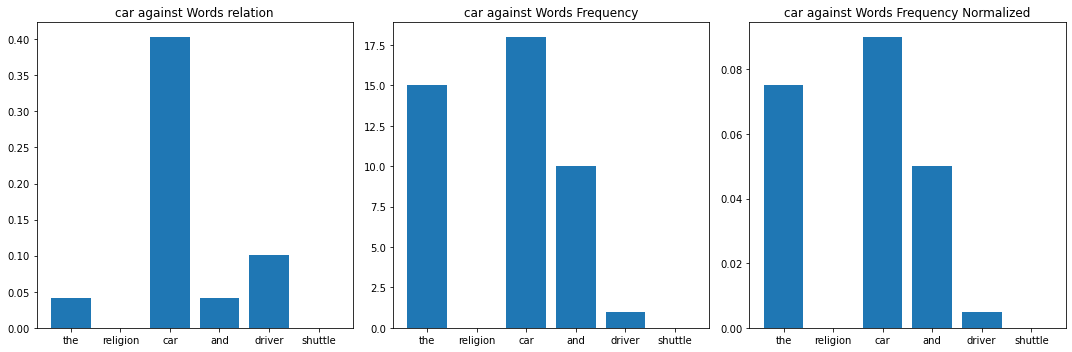

In [857]:
word = "car"
words = ["the", "religion", "car", "and", "driver", "shuttle"]

# words = np.array(vocabulary)[np.random.randint(len(vocabulary), size=5)]
# word = words[0]

fig = plt.figure(figsize=(15,5), tight_layout=True)
ax11 = fig.add_subplot(131)
ax12 = fig.add_subplot(132)
ax13 = fig.add_subplot(133)

ax11.set_title(f"{word} against Words relation")
ax11.bar(words, word_word_co.loc[word][words])

pxy = word_doc_frequency[word_doc_frequency[word] == 1].sum(0)

ax12.set_title(f"{word} against Words Frequency")
ax12.bar(words, pxy[words])

pxy /= total_num_of_documents

ax13.set_title(f"{word} against Words Frequency Normalized")
ax13.bar(words, pxy[words])

plt.show()

### Setup Doc Word Distr

In [870]:
number_of_iterations = 1
doc_word_distr = word_doc_frequency_norm.copy()

total_iterations = number_of_iterations * total_num_of_documents

with tqdm(total=total_iterations) as pbar:
    for n_iter in range(number_of_iterations):
        for doc_index in (range(total_num_of_documents)):
            
            words = selected_best_words[doc_word_distr.loc[doc_index] > 0]
            xv = (doc_word_distr.loc[doc_index][words] * word_word_co.loc[words].T).T
            doc_word_distr.loc[doc_index] = xv.mean(0)
            pbar.update(1)
            
        print(f"overall probability sum in docs {doc_word_distr.sum().sum()}")

overall probability sum in docs 836.4866580217604



In [871]:
doc_word_distr.head()

,000,0098,031349,0878,0b1fatransfer,10,1000,11,12,12cyl,...,yet,yo,york,yorker,you,your,yours,yourself,yourselves,zuma
0,0.002466,0.000874,0.002308,0.000000,0.001172,0.002599,0.001916,0.001113,0.001404,0.000986,...,0.003431,0.001281,0.000844,0.003016,0.002023,0.001655,0.001172,0.001702,0.001395,0.001743
1,0.003832,0.002003,0.004098,0.000000,0.001465,0.003101,0.001512,0.003006,0.002958,0.001973,...,0.004238,0.002779,0.001497,0.003492,0.002651,0.002608,0.001465,0.002958,0.003049,0.004494
2,0.002254,0.000408,0.002386,0.000000,0.001059,0.001961,0.000897,0.002180,0.002960,0.001356,...,0.002316,0.001770,0.003072,0.002969,0.002124,0.001876,0.001059,0.002065,0.002088,0.001082
3,0.001390,0.000000,0.001154,0.000000,0.001490,0.000871,0.001197,0.000679,0.000924,0.001539,...,0.001812,0.000946,0.000924,0.000923,0.001327,0.000879,0.001490,0.000679,0.000694,0.000230
4,0.002844,0.001374,0.003401,0.000523,0.003703,0.012015,0.003564,0.002406,0.003144,0.001820,...,0.001768,0.002107,0.001851,0.004310,0.002381,0.002437,0.003703,0.004303,0.001722,0.002913


In [872]:
doc_index = 13
word_doc_frequency_norm.iloc[doc_index].sort_values(ascending=False).head(5)

the        0.09375
they       0.06250
can        0.06250
sure       0.03125
imagine    0.03125
Name: 13, dtype: float64

In [873]:
doc_word_distr.loc[doc_index].sort_values(ascending=False).head(5)

nucleus    0.017078
hundred    0.017078
coma       0.017078
almost     0.017078
within     0.010553
Name: 13, dtype: float64

In [874]:
word_word_co.loc["nucleus"].sort_values(ascending=False)

almost     0.848906
hundred    0.848906
coma       0.848906
nucleus    0.848906
figure     0.424453
             ...   
phobos     0.000000
phone      0.000000
pickup     0.000000
piece      0.000000
000        0.000000
Name: nucleus, Length: 2060, dtype: float64

In [875]:
print(f"Topic: {labels[doc_index]}\n{'='*50}\n{train_docs[doc_index]}")

Topic: sci.space
i m not sure but it almost sound like they can t figure out where the nucleus be within the coma if they re off by a couple hundred mile well you can imagine the rest


### Define Latent partitions

In [915]:
# reduction = None
reduction = "pca"
# reduction = "normal"

if reduction is None:
    columns = doc_word_distr.columns
    param_values = doc_word_distr.values

if reduction == "pca":
    num_of_components = 4
    columns = list(range(num_of_components))
    
    pca = PCA(n_components=num_of_components, whiten=True)
    param_values = pca.fit_transform(doc_word_distr)

if reduction == "normal":
    columns = ["mean", "std"]
    column_values = [doc_word_distr.sum(1), doc_word_distr.mean(1)]
    param_values = np.array(column_values).T
    
distr_params = pd.DataFrame(data=param_values, columns=columns, index=list(range(len(doc_word_distr))))
print(f"distr_params has shape {distr_params.shape}")

distr_params has shape (200, 4)


In [916]:
distr_params.head()

,0,1,2,3
0,-0.394550,0.467248,1.156211,-0.156453
1,1.254347,1.025711,-0.295810,1.334139
2,0.435612,1.309399,-1.104340,-0.951830
3,-1.632810,0.726976,1.461383,-1.268605
4,0.581701,-0.843140,-1.096390,-0.089863


### Using Kmeans MiniBatch

In [917]:
num_of_topics = 4

In [918]:
kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params)

In [919]:
dist = kmeans_model.transform(distr_params)
predicted_labels = kmeans_model.predict(distr_params)
wtf = gaussian(normalize(dist, norm="l1", axis=1))

print(f"dist has shape {dist.shape}, predicted_labels has shape {predicted_labels.shape}")

dist has shape (200, 4), predicted_labels has shape (200,)


In [920]:
Counter(predicted_labels)

Counter({1: 92, 0: 37, 2: 33, 3: 38})

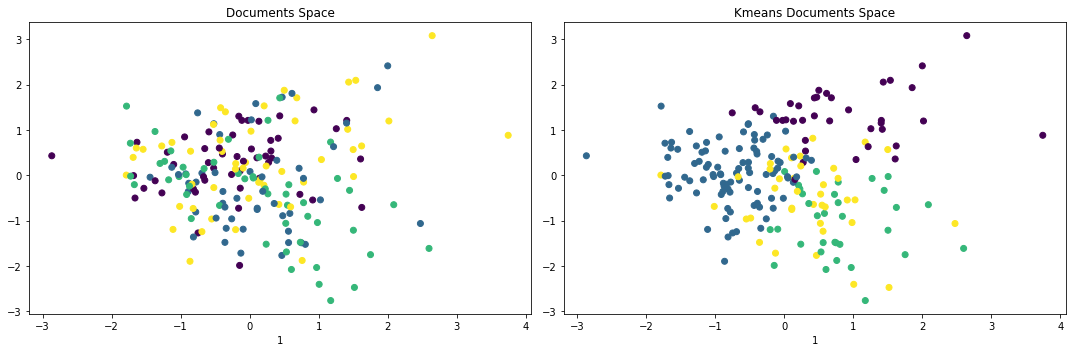

In [921]:
fig = plt.figure(figsize=(15,5), tight_layout=True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title("Documents Space")
ax1.scatter(param_values[:, 0], param_values[:,1], c = label_indices)
ax1.set_xlabel(columns[0])
ax1.set_xlabel(columns[1])

ax2.set_title("Kmeans Documents Space")
ax2.scatter(param_values[:, 0], param_values[:,1], c = predicted_labels)
ax2.set_xlabel(columns[0])
ax2.set_xlabel(columns[1])

plt.show()

In [922]:
def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    print(doc_word_distr.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords(topic):
    indices = np.where(predicted_labels == topic)[0]
    print((doc_word_distr.T * wtf[:, topic]).T.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    xv = (doc_word_distr.T * wtf[:, topic]).T.iloc[indices]
    xvc = (xv > 0).sum(0)
    print((xv.sum(0) * calculate_trust_ratio(xvc) / xvc).sort_values(ascending=False).head(10))

def get_top2(topic):
    indices = dist[:, topic].argsort()
    print(labels[indices[:10]])
    get_topwords(topic)
    
def get_top(topic):
    indices = np.where(predicted_labels == topic)[0]
    count = Counter()
    for index in indices:
        count[labels[index]] += wtf[index, topic]
        
    print(Counter(labels[indices]))
    get_topwords(topic)

In [923]:
get_top(0)

Counter({'sci.space': 15, 'rec.autos': 11, 'talk.politics.mideast': 9, 'alt.atheism': 2})
various        0.003966
common         0.003966
hardly         0.003966
era            0.003966
foreign        0.003966
quite          0.003697
total          0.003689
competetors    0.003689
purse          0.003689
motocycle      0.003689
dtype: float64


In [924]:
get_top(1)

Counter({'rec.autos': 28, 'alt.atheism': 23, 'talk.politics.mideast': 21, 'sci.space': 20})
acknowledge    0.002288
ahead          0.002288
lane           0.002288
extend         0.002288
semi           0.002288
ssto           0.002230
lease          0.002230
cheaper        0.002230
facility       0.002230
pad            0.002230
dtype: float64


In [925]:
get_top(2)

Counter({'alt.atheism': 16, 'talk.politics.mideast': 8, 'sci.space': 6, 'rec.autos': 3})
fabrication    0.004574
bedouin        0.004574
helpful        0.004574
feedback       0.004574
assumes        0.004574
happy          0.004574
accuracy       0.004574
danhy          0.004574
judge          0.004178
chrismas       0.004050
dtype: float64


In [926]:
get_top(3)

Counter({'talk.politics.mideast': 12, 'alt.atheism': 9, 'sci.space': 9, 'rec.autos': 8})
explain      0.003701
pertains     0.003701
position     0.003489
satan        0.003359
freewill     0.003359
angel        0.003359
shift        0.003311
funding      0.003311
advantage    0.003311
federal      0.003311
dtype: float64


### LDA